<a href="https://colab.research.google.com/github/funCode9/Image-Classification---GenAI-task/blob/main/GenAI_2025A7PS0030H.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/archive.zip', 'r')
zip_ref.extractall('/content/local_data')
zip_ref.close()

In [ ]:
!pip install split-folders
import os
import splitfolders

# Splitting the dataset into 80% Train, 10% Val, 10% Test.
splitfolders.ratio('/content/local_data/Garbage classification/Garbage classification',output="split_data",seed=42,ratio=(.8, .1, .1))
print("Folders created:")
print(os.listdir('split_data/train'))

Copying files: 2527 files [00:00, 7670.50 files/s]

Folders created:
['trash', 'plastic', 'glass', 'metal', 'cardboard', 'paper']


In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
# Numbers sourced from ImageNet (standard values)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [ ]:
# SIMPLE TRANSFORMS (No Augmentation)
transform_simple = transforms.Compose([
    transforms.Resize((224, 224)), # All images must be the same size
    transforms.ToTensor(),         # Convert pixels to numbers (0 to 1)
    transforms.Normalize(mean,std)   # Centers the data around zero
])

In [ ]:
# AUGMENTED TRANSFORMS
# Implemented basic data augmentation like flips, rotations, and tuned brightness
transform_aug = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5), # image has 50% chance to flip
    transforms.RandomRotation(20),          # image can rotate up to 20 degrees
    transforms.ColorJitter(brightness=0.2), # changing brightness upto by 20%
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])

In [ ]:
train_dir = 'split_data/train'
val_dir = 'split_data/val'

train_set = datasets.ImageFolder('split_data/train', transform=transform_simple)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)

train_set_aug = datasets.ImageFolder('split_data/train', transform=transform_aug)
train_loader_aug = DataLoader(train_set_aug, batch_size=32, shuffle=True)

val_set = datasets.ImageFolder('split_data/val', transform=transform_simple)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)

print("Number of classes:", len(train_set.classes))
for cls in train_set.classes:
  print(cls)

Number of classes: 6
cardboard
glass
metal
paper
plastic
trash


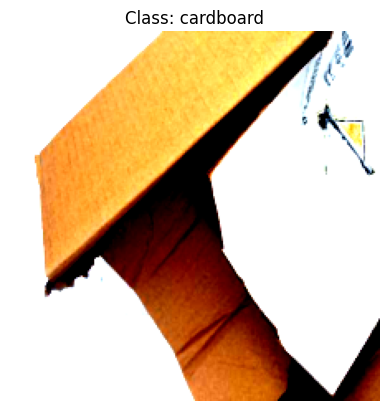

In [ ]:
import matplotlib.pyplot as plt

# Getting 1 batch of images from the loader
images, labels = next(iter(train_loader))

# accesing 1st image from the batch
# PyTorch stores images as [Color, Height, Width], but Matplotlib needs [Height, Width, Color]
single_img = images[0].permute(1, 2, 0)

# used clamp as any number less than 0 becomes exactly 0 (pure black), and any number greater than 1 becomes exactly 1 (pure white).
single_img = single_img.clamp(0, 1)

plt.imshow(single_img)
plt.title(f"Class: {train_set.classes[labels[0]]}")
plt.axis('off')
plt.show()

In [ ]:
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        # First layer
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)

        # Second layer
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)

        # Fully connected layers at the end
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 54 * 54, 128) # calculation of size (channels*height*width, features)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 6) # 6 classes of garbage

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = MyModel().to(device)

In [ ]:
#running scratch model with no augmentation

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)

for epoch in range(5):
    model1.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model1(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Checking accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(train_loader)
    avg_acc = 100 * correct / total

    print(f"Epoch {epoch+1} done. Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.2f}%")

Epoch 1 done. Loss: 1.8066, Accuracy: 34.13%
Epoch 2 done. Loss: 1.1719, Accuracy: 54.33%
Epoch 3 done. Loss: 0.8221, Accuracy: 70.63%
Epoch 4 done. Loss: 0.4414, Accuracy: 84.99%
Epoch 5 done. Loss: 0.2423, Accuracy: 92.62%


In [ ]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim

# Loading pre-tained ResNet18 model
model_resnet = models.resnet18(weights='DEFAULT')

# Freezing the model
for param in model_resnet.parameters():
    param.requires_grad = False

# The original model was made for 1000 classes, but there are 6 garbage types So replaced 'fc' (fully connected) layer with a new one
input_features = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(input_features, 6)

# Moved the model to GPU
model_resnet = model_resnet.to(device)

# Setting up the optimizer
optimizer_resnet = optim.Adam(model_resnet.fc.parameters(), lr=0.001)

# Loss function
loss_fn = nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 72.5MB/s]


In [ ]:
# Resnet model + augmentation
epochs = 5         # no of iterations

for epoch in range(epochs):
    model_resnet.train()
    running_loss = 0.0

    for images, labels in train_loader_aug:
        images, labels = images.to(device), labels.to(device) #

        optimizer_resnet.zero_grad()           # Clearing old mistakes (gradients)
        outputs = model_resnet(images)         # Makes a guess (Forward Pass)


        _, predicted = torch.max(outputs, 1)                 # Picks the category with the highest score
        correct_count = (predicted == labels).sum().item()   # Counts matches

        loss = criterion(outputs, labels)    # Calculates how wrong the guess was
        loss.backward()                      # Finds out which 'knobs' to turn
        optimizer_resnet.step()                # turns the knobs  (tuning)

        running_loss += loss.item()

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_acc = 100 * correct / total
    avg_loss = running_loss/len(train_loader_aug)

    print(f"Epoch {epoch+1} Average Loss: {avg_loss:.4f} Accuracy: {avg_acc:.2f}% ")

Epoch 1 Average Loss: 1.3274 Accuracy: 72.09% 
Epoch 2 Average Loss: 0.9365 Accuracy: 70.86% 
Epoch 3 Average Loss: 0.8037 Accuracy: 71.45% 
Epoch 4 Average Loss: 0.7379 Accuracy: 72.25% 
Epoch 5 Average Loss: 0.6722 Accuracy: 73.24% 


In [ ]:
# finally running all 4 combinations of the 2 models and 2 transforms

models_to_train = [model1, model1, model_resnet, model_resnet]
loaders_to_train = [train_loader, train_loader_aug, train_loader, train_loader_aug]
case_names = ["Scratch Model + No augmentation", "Scratch model + augmentation", "ResNet model + no augmentation", "ResNet model + augmentation"]

#storing final accuracy in this dict
final_results = {}


for i in range(4):
    print(f"\n--- CASE : {case_names[i]} ---")

    current_model = models_to_train[i]
    current_loader = loaders_to_train[i]

    optimizer = optim.Adam(current_model.parameters(), lr=0.001)
    final_results[case_names[i]] = [[],[]]

    for epoch in range(5):
        current_model.train()
        correct = 0
        total = 0
        running_loss = 0.0


        for images, labels in current_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = current_model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total

        final_results[case_names[i]][0].append(running_loss)
        final_results[case_names[i]][1].append(accuracy)

        print(f"Epoch {epoch+1}\t Average Loss: {running_loss/len(current_loader):.4f}\t Accuracy: {accuracy:.2f}%")


    print(f"FINAL ACCURACY for {case_names[i]}: {final_results[case_names[i]][1][-1]:.2f}%")
print("\n--- ALL 4 CASES FINISHED ---")

print(final_results)


--- CASE : Scratch Model + No augmentation ---
Epoch 1	 Average Loss: 0.1421	 Accuracy: 95.54%
Epoch 2	 Average Loss: 0.0678	 Accuracy: 97.87%
Epoch 3	 Average Loss: 0.0529	 Accuracy: 98.61%
Epoch 4	 Average Loss: 0.0676	 Accuracy: 98.42%
Epoch 5	 Average Loss: 0.0464	 Accuracy: 98.76%
FINAL ACCURACY for Scratch Model + No augmentation: 98.76%

--- CASE : Scratch model + augmentation ---
Epoch 1	 Average Loss: 1.4947	 Accuracy: 57.16%
Epoch 2	 Average Loss: 0.9232	 Accuracy: 67.81%
Epoch 3	 Average Loss: 0.8234	 Accuracy: 70.78%
Epoch 4	 Average Loss: 0.7374	 Accuracy: 74.10%
Epoch 5	 Average Loss: 0.6827	 Accuracy: 77.02%
FINAL ACCURACY for Scratch model + augmentation: 77.02%

--- CASE : ResNet model + no augmentation ---
Epoch 1	 Average Loss: 0.6318	 Accuracy: 77.56%
Epoch 2	 Average Loss: 0.5871	 Accuracy: 79.99%
Epoch 3	 Average Loss: 0.5174	 Accuracy: 81.77%
Epoch 4	 Average Loss: 0.4963	 Accuracy: 82.91%
Epoch 5	 Average Loss: 0.4708	 Accuracy: 84.84%
FINAL ACCURACY for ResNet

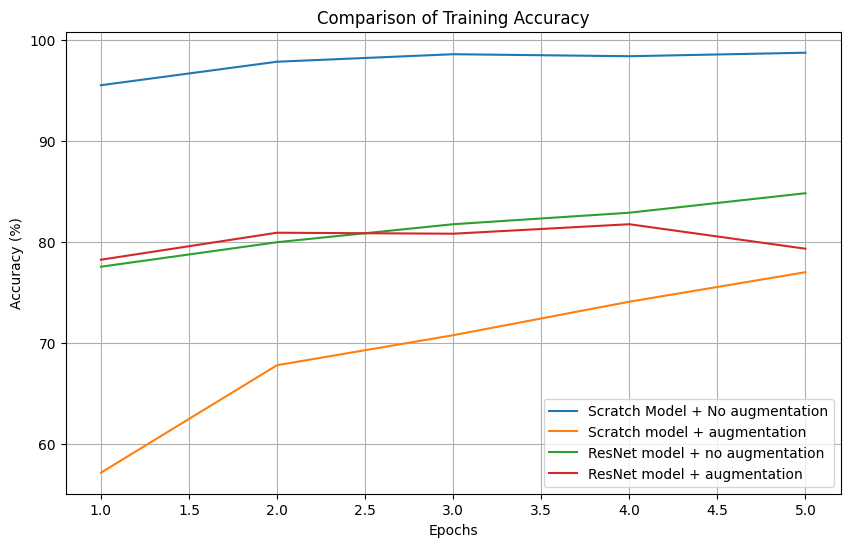

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, 6)

plt.figure(figsize=(10, 6))

for j in range(4):
    plt.plot(epochs, final_results[case_names[j]][1], label=f'{case_names[j]}')

plt.title('Comparison of Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

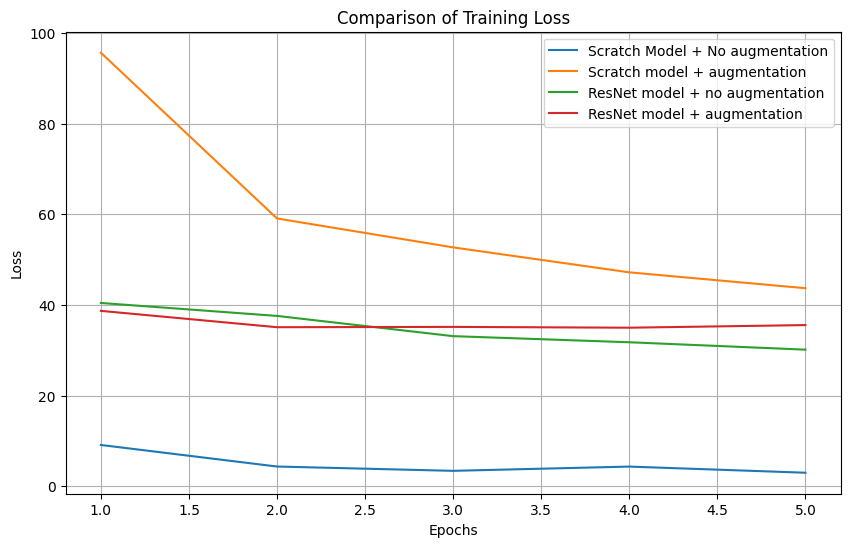

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, 6)

plt.figure(figsize=(10, 6))

for j in range(4):
    plt.plot(epochs, final_results[case_names[j]][0], label=f'{case_names[j]}')

plt.title('Comparison of Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

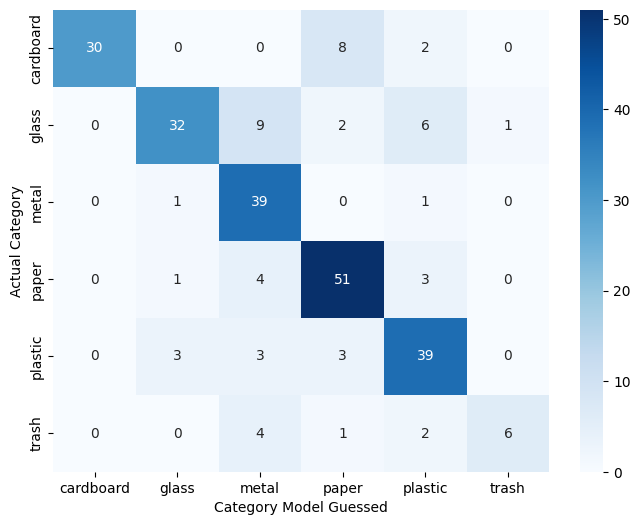

In [ ]:
# model guessing images from validation set
model_resnet.eval()
actual_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in val_loader:

        images = images.to(device)
        outputs = model_resnet(images)
        _, preds = torch.max(outputs, 1)

        predicted_labels.extend(preds.tolist())
        actual_labels.extend(labels.tolist())


# getting heatmap from the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(actual_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True,cmap='Blues', xticklabels=train_set.classes, yticklabels=train_set.classes)
plt.ylabel('Actual Category')
plt.xlabel('Category Model Guessed')
plt.show()

In [ ]:
from PIL import Image

def predict_image(image_path, model, class_names):

    img = Image.open(image_path).convert('RGB')

    img_t = transform_simple(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(img_t)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        confidence, predicted = torch.max(probabilities, 0)

    plt.imshow(img)
    plt.title(f"Prediction: {class_names[predicted.item()]} ({confidence.item()*100:.2f}%)")
    plt.axis('off')
    plt.show()


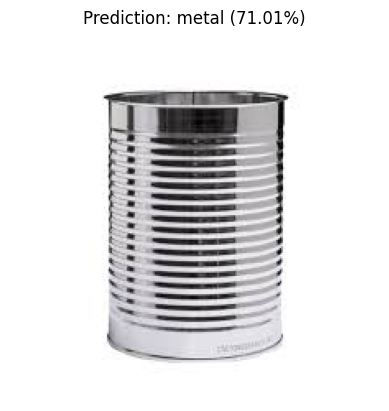

In [ ]:
predict_image('/content/drive/MyDrive/testpics/img1.jpeg', model_resnet, train_set_aug.classes)

Correct Answer : Metal

Prediction : Correct


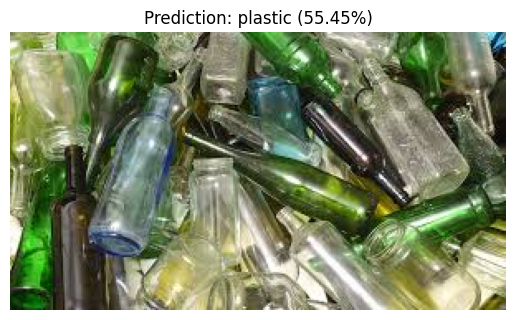

In [ ]:
predict_image('/content/drive/MyDrive/testpics/img2.jpeg', model_resnet, train_set_aug.classes)

Correct Answer : Glass

Prediction : Wrong

Possible reason of incorrect guess: since it has dense pile of bottles and the colour itself does not differentiate between plastic and glass that is why model might have mistaken it for plastic.




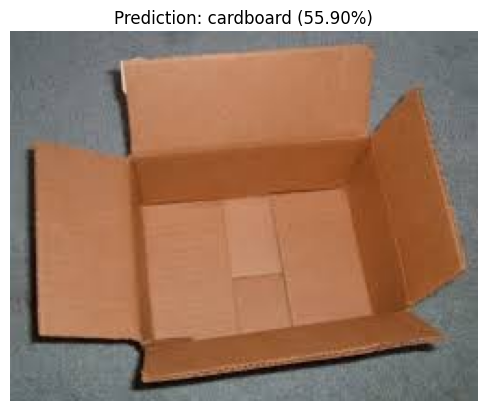

In [ ]:
predict_image('/content/drive/MyDrive/testpics/img3.jpeg', model_resnet, train_set_aug.classes)

Correct Answer : Cardboard

Prediction : Correct




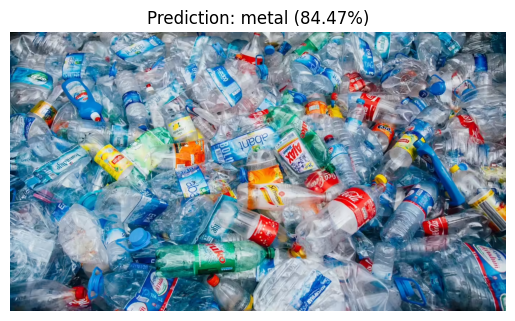

In [ ]:
predict_image('/content/drive/MyDrive/testpics/img4.jpeg', model_resnet, train_set_aug.classes)

Correct Answer : Plastic

Prediction : Wrong

Possible reason of incorrect guess: since it has dense pile of bottles and also a lot of shining component that is why model might have mistaken it for metal.




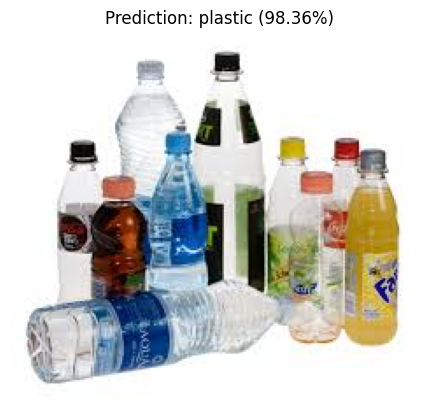

In [ ]:
predict_image('/content/drive/MyDrive/testpics/img5.jpeg', model_resnet, train_set_aug.classes)

Correct Answer : Plastic

Prediction : Correct


